In [0]:
# !pip3 install torch 
# !pip3 install torchvision
# !pip3 install tqdm
# !pip install pbd
# !pip install Pillow
# !pip install image
# !pip install --no-cache-dir -I pillow
# !pip install imageio

import torch
from tqdm import tqdm
from torch import autograd
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils, datasets
import torchvision
from torch.autograd import Variable 

import time
import numpy as np
import os
import gc
import pdb
from io import open
import string
import re
import random
import matplotlib.pyplot as plt

from torchvision.transforms import ToPILImage
from PIL import Image
from imageio import imread
from scipy import ndimage
to_img = ToPILImage()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
class ImageDataset(Dataset):
  """
  Handles the loading in of pictures and resizes them for the models to use
  """
  def __init__(self, root='/content/gdrive/My Drive/School/2018_Fall/CS_501R/Labs/FinalProject/nmist', size=1024, Train=True):
    super(ImageDataset, self).__init__()
#     transforms.CenterCrop((size,size)), DONT USE RIGHT NOW
    self.dataset_folder = torchvision.datasets.ImageFolder(os.path.join(root) ,transform = transforms.Compose([transforms.Resize((256,256)),transforms.ToTensor()]))
    self.angles = [0, 90, 180, 270]
    
  def __getitem__(self,index):
    """
    Returns a rotated image and its original unrotated counterpart
    """
    img = np.absolute(self.dataset_folder[index][0])
    angle = random.choice(self.angles)
    rotated = torch.tensor(np.absolute(ndimage.interpolation.rotate(img, angle, (1,2))))
    return rotated, self.angles.index(angle)
 
  def __len__(self):
    return len(self.dataset_folder)
  

In [0]:
class FinalNet(nn.Module):
  def __init__(self, num_classes=4):
    super(FinalNet, self).__init__()
    self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
        
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
        
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
    
    self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 7 * 7, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )
    
  def forward(self, x):
#     print(x.shape)
    x = self.features(x)
#     print(x.shape)
    x = x.view(x.size(0), 256 * 7 * 7)
    x = self.classifier(x)
    return x

In [0]:
train_dataset = ImageDataset(Train=True)
train_loader = DataLoader(train_dataset, batch_size=1, num_workers=0, shuffle=True)

In [0]:
epochs = 60
epoch_loss = []

In [0]:
net = FinalNet().cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.0005, momentum=0.9, weight_decay=0.0005)

In [0]:
for epoch in range(epochs):  # loop over the dataset multiple times
    
  batch_loss = []
  for i, data in enumerate(train_loader):
    # get the inputs

    rotated_imgs, angles = data   
    rotated_imgs = rotated_imgs.cuda()
    angles = angles.cuda()
    
    # zero the parameter gradients
    optimizer.zero_grad()

    outputs = net(rotated_imgs)

    loss = criterion(outputs, angles)
    loss.backward()
    optimizer.step()
    batch_loss.append(loss.item())

    if i % 10 == 0:    # print every 2000 mini-batches
      print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, batch_loss[-1]))
      print(angles)
      print(outputs)

  torch.save(net.cpu(), '/content/gdrive/My Drive/final_model.pt')
  epoch_loss.append(np.mean(batch_loss))
  
  
print('Finished Training', np.mean(epoch_loss))

[1,     1] loss: 1.394
tensor([3], device='cuda:0')
tensor([[ 0.0223, -0.0041,  0.0116, -0.0005]], device='cuda:0',
       grad_fn=<AddmmBackward>)
[1,    11] loss: 1.393
tensor([3], device='cuda:0')
tensor([[ 0.0234, -0.0054,  0.0068, -0.0006]], device='cuda:0',
       grad_fn=<AddmmBackward>)
[1,    21] loss: 1.390
tensor([3], device='cuda:0')
tensor([[ 0.0186, -0.0081,  0.0072,  0.0007]], device='cuda:0',
       grad_fn=<AddmmBackward>)
[1,    31] loss: 1.389
tensor([1], device='cuda:0')
tensor([[0.0097, 0.0038, 0.0074, 0.0073]], device='cuda:0',
       grad_fn=<AddmmBackward>)
[1,    41] loss: 1.389
tensor([3], device='cuda:0')
tensor([[0.0019, 0.0048, 0.0161, 0.0043]], device='cuda:0',
       grad_fn=<AddmmBackward>)
[1,    51] loss: 1.406
tensor([0], device='cuda:0')
tensor([[-0.0129, -0.0040,  0.0289,  0.0145]], device='cuda:0',
       grad_fn=<AddmmBackward>)
[1,    61] loss: 1.411
tensor([0], device='cuda:0')
tensor([[-0.0193, -0.0051,  0.0334,  0.0104]], device='cuda:0',
    

torch.Size([3, 256, 256])
torch.Size([256, 3, 256])
torch.Size([256, 256, 3])


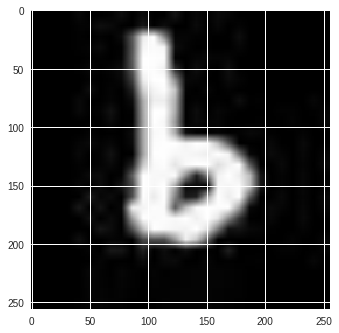

torch.Size([3, 256, 256])
180
(256, 256, 3)


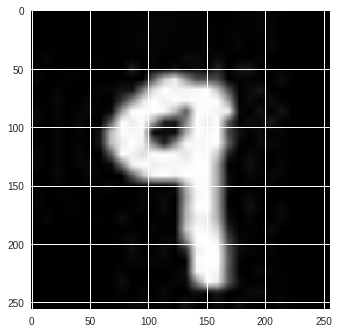

In [0]:
img = train_dataset[100][0]

angles = [0, 270, 180, 90]
print(img.shape)
img2 = np.swapaxes(img, 0, 1)
print(img2.shape)
img2 = np.swapaxes(img2, 1,2)
print(img2.shape)

plt.imshow(img2)
plt.show()

# img = img.cuda()
print(img.shape)
angle = net(img.unsqueeze(0))
off_angle = angles[np.argmax(angle.cpu().detach().numpy())]
print(off_angle)

corrected = np.absolute(ndimage.interpolation.rotate(img2, off_angle, (0,1)))
print(corrected.shape)
plt.imshow(corrected)
plt.show()

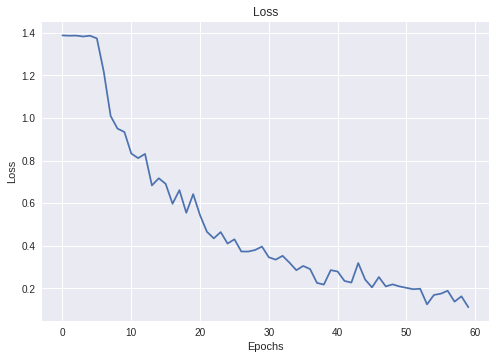

In [0]:
plt.plot(range(len(epoch_loss)), epoch_loss)
plt.title("Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()